# model using transformed target

same linear model as in notebook_3 but using a quartile transformation for the target

In [10]:
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

from utils import *
df_hour = pd.read_csv("hour.csv")

In [2]:
# adding 3h and 1w features
names = []
for i,name in [ (3,"3h") ,(24*7,"1w")]:
    %%time df_hour[name]= df_hour["instant"].apply(lambda x: aggregate_last_n_hours(df_hour,x,i)  )
    names.append(name)

Wall time: 1.49 s
Wall time: 1min 33s


In [4]:
preliminary_features = ["season","mnth","hr","holiday","weekday","workingday","weathersit","temp","hum","windspeed","cnt"]
df = df_hour[ preliminary_features + names ]

In [5]:
#encoding categorical
categorical2encode = ["season","mnth","hr","weekday","weathersit"]
df = one_hot_encode(df,categorical2encode)

Number of model features after one-hot encoding: 58


In [6]:
# train test split
X_train, y_train, X_test, y_test = split_train_test(df,fraction_train=0.8)

In [7]:
# scaling 1w and 3h using MinMaxScaler fitted to training data. Test data not used to avoide leakage 
scalers = {}
for name in ["3h","1w"]:
    scaler = MinMaxScaler()
    feature_name = name+"_scaled"
    X_train[feature_name]=scaler.fit_transform( X_train[name].values.reshape(-1, 1) )   
    X_train.drop(columns=name,inplace=True)
    scalers[name] = scaler

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [23]:
# definning split for forward-validation
n_splits=5
tscv = TimeSeriesSplit(n_splits=n_splits)
model = ElasticNet(max_iter=3000,tol=1e-5)
# training and hyper-parameter optimization:
### log-transformation of target
qt = QuantileTransformer(output_distribution='normal', random_state=0)
qt.fit(y_train.values.reshape(-1, 1))
regr_trans = TransformedTargetRegressor(regressor=ElasticNet(),transformer=qt)
##sub-space of hyper-parameters:
parameters = {'alpha':[1e-3,5e-3,1e-2,5e-2,1e-1,1,5], 'l1_ratio':[0.05,0.25,0.5,0.75,1.0]}
parameters_logtarget = {'regressor__alpha':parameters["alpha"], 'regressor__l1_ratio': parameters["l1_ratio"]}
clf_lognormtarget = GridSearchCV(regr_trans, parameters_logtarget, cv=tscv,scoring="neg_mean_absolute_error",n_jobs=-1)
%time clf_lognormtarget.fit(X_train,y_train)

Wall time: 5.04 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol...=False, n_quantiles=1000,
          output_distribution='normal', random_state=0, subsample=100000)),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5], 'regressor__l1_ratio': [0.05, 0.25, 0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [12]:
#transforming test set for predictions
for name in ["3h","1w"]:
    feature_name = name+"_scaled"
    X_test[feature_name] = scalers[name].transform( X_test[name].values.reshape(-1, 1) )   
    X_test.drop(columns=name,inplace=True)

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<IPython.core.display.Javascript object>


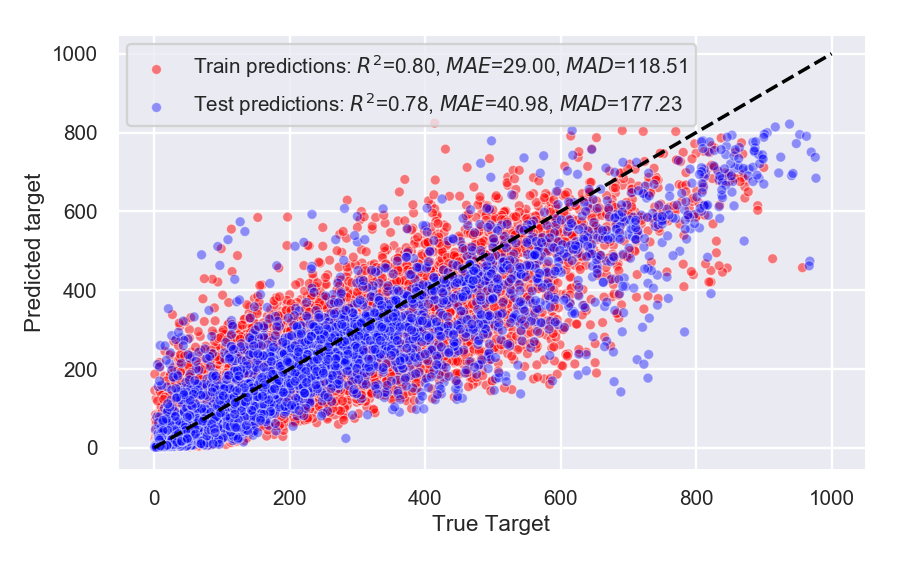

In [24]:
y_train_pred = clf_lognormtarget.predict(X_train) 
y_test_pred = clf_lognormtarget.predict(X_test)
saveplot="error_on_test_set"
compare_predictions_vs_true(y_train_pred,y_train,y_test_pred,y_test)#,saveplot)

## Prediction interval for model 

In a regression problem one does not predict a precise value but rather an interval with some probability that the real outcome is within such range. 

For a gaussian(-like) distributed data, a prediction interval with confidence 95% is the range of values with 2\*$\sigma$ around the predicted outcome, e.g.  $y_{pred} \pm 2*\sigma $. (z-score)

If the developed model is a good representation of the data one expects small residuals between predicted and true values,  with a distribution centered around zero, having small std dev. and being approximately independent of the true value.

Let's check the residuals distribution for the test set:

<IPython.core.display.Javascript object>


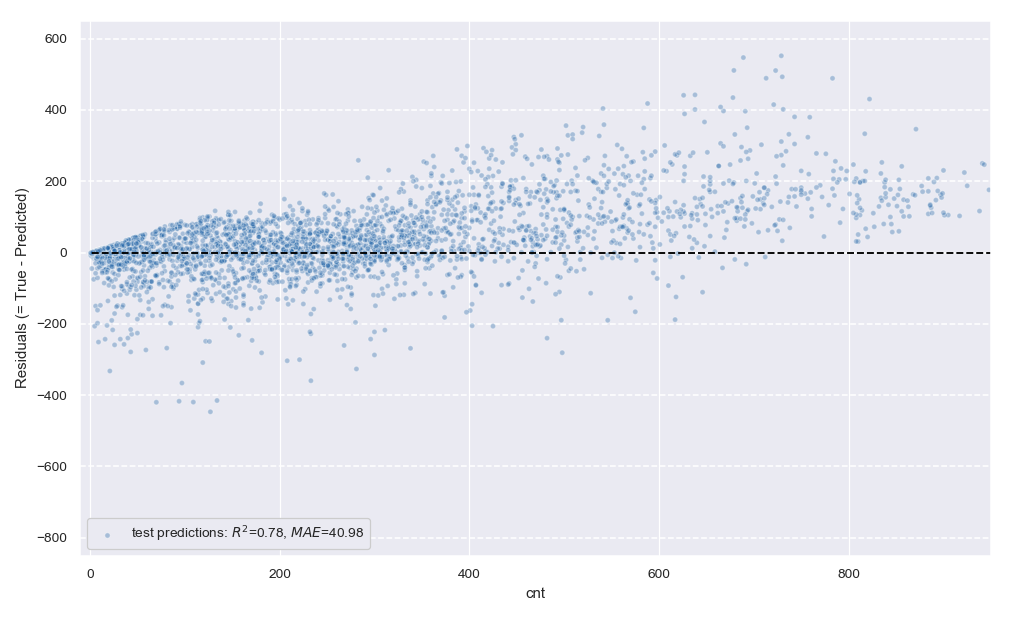

In [25]:
sns.set_context("paper")
residuals_predictions = plot_residuals(y_test,{"test predictions":y_test_pred}, saveplot="")

<IPython.core.display.Javascript object>


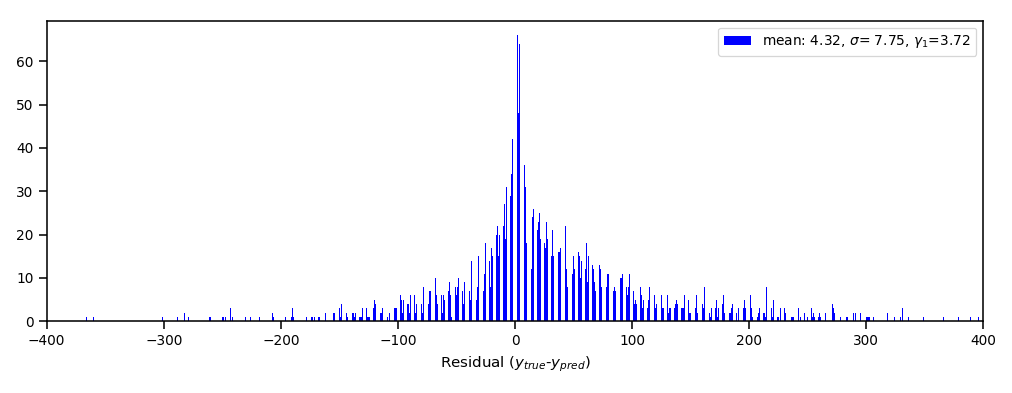

In [15]:
plt.figure(figsize=(9,3.5))
bin_cnts, bins =np.histogram(residuals_predictions,bins=800,range=(-400,400))
plt.bar(x=bins[:-1],height=bin_cnts, color= "blue",linewidth=0,width=0.5,label="mean: {:0.2f}, $\sigma$= {:0.2f}, $\gamma_1$={:0.2f}".format(bin_cnts.mean(),bin_cnts.std(),stats.skew(bin_cnts)))
plt.gca().set( xlabel="Residual ($y_{true}$-$y_{pred}$)",xlim=(-400,400))
plt.legend()
plt.tight_layout()